# Literature Review

In [3]:
from pathlib import Path

data_file = lambda filename: Path().resolve().parent.joinpath(*['data', filename])
cache_file = lambda filename: Path().resolve().parent.joinpath(*['cache', filename])
figure_file = lambda filename: Path().resolve().parent.joinpath(*['figures', filename])

def createDirectories():
    DATA = Path().resolve().parent.joinpath('data')
    CACHE = Path().resolve().parent.joinpath('cache')
    FIGURES = Path().resolve().parent.joinpath('figures')
    for directory in [DATA, CACHE, FIGURES]:
        try:
            directory.mkdir()
            print('directory created')
        except FileExistsError:
            print('directory already exists')

In [4]:
from google.cloud import bigquery
import pandas as pd
from tqdm import tqdm
from google.cloud import bigquery
from concurrent.futures import TimeoutError
import os
import numpy as np
import json

"""BIG QUERY FUNCTIONS"""

def client():
    """require a bigquery project and credentials, save in json in root main directory"""
    credsfile = Path().resolve().parent.joinpath('credentials.json')
    creds = json.load(open(credsfile))
    PROJECT = creds["PROJECT"]
    CREDENTIALS = Path().resolve().parent.joinpath(creds["CREDENTIALS"])
    return bigquery.Client.from_service_account_json(CREDENTIALS, project=PROJECT)

def jobConfig():
    config = bigquery.QueryJobConfig()
    config.query_parameters = (bigquery.ScalarQueryParameter('size', 'INT64', 10),)
    config.use_legacy_sql = False
    config.maximum_bytes_billed = int(5e9)
    
    return config

def run_job(query):
    print('Submitting query')
    j = client().query(query=query, job_config=jobConfig())
    with tqdm() as pbar:
        while True:
            try:
                j.result(timeout=1)
            except TimeoutError:                
                pbar.update(1)
            else:
                break
    return j

def unpack_results(j):
    print('Unpacking results')
    
    total = j.query_results().total_rows
    
    iterator = j.result()
    rows = []
    for row in tqdm(iterator, total=total):
        rows.append(row.values())
    
    columns = [c.name for c in iterator.schema]
    df = pd.DataFrame(rows, None, columns)
    
    return df


def fetchQuery(query):
    j = run_job(query)
    df = unpack_results(j)
    
    return df

In [6]:
def getSampleSubreddits(LIMIT=1000):
    query = """SELECT subreddit, COUNT(*) as comment_count
                FROM `fh-bigquery.reddit_comments.2017_06`
                WHERE subreddit NOT IN ('The_Donald', 'changemyview')
                GROUP By subreddit
                HAVING COUNT(*) >= 1000
                ORDER BY RAND()
                LIMIT {}""".format(LIMIT)

    df = fetchQuery(query)
    df.to_csv(data_file('sampleSubreddits.csv'))
    
def getSubredditInCounts(nSampleSubreddits=100):
    sampleSubreddits = pd.read_csv(data_file('sampleSubreddits.csv'))
    subs = set(['The_Donald', 'changemyview'] + list(sampleSubreddits['subreddit'].sample(nSampleSubreddits)))
    names = "'" + "','".join(subs)+ "'"
    query = """SELECT subreddit, author, COUNT(*) as count
                    FROM `fh-bigquery.reddit_comments.2017_06`
                    WHERE (subreddit IN ({})) and (author NOT IN ('[deleted]'))
                    GROUP BY subreddit, author""".format(names)

    df = fetchQuery(query)
    df.to_csv(data_file('sampleSubredditInCounts.csv'))
    
def fetchAllCounts():
    inCounts = pd.read_csv(data_file('SubredditInCounts.csv'), index_col=0)

    authors = list(inCounts['author'].unique())
    blocks = [15000*n for n in range (0,int(len(authors)+1/15000))]
    ranges = list(zip(blocks, blocks[1:]))

    chunks = []
    for r in ranges:
        start, end = r
        chunks.append(authors[start:end])
    chunks.append(authors[blocks[-1]:])

    dfs = []
    for c in tqdm(chunks):
        names = "'" + "','".join(c)+ "'"
        query = """SELECT subreddit, author, COUNT(*) as count
                        FROM `fh-bigquery.reddit_comments.2017_06`
                        WHERE (author IN ({})) and (author NOT IN ('[deleted]'))
                        GROUP BY subreddit, author""".format(names)

        df = fetchQuery(query)
        dfs.append(df)
    
    return dfs

def saveCommentCounts():
    dfs = fetchAllCounts()
    allCounts = pd.concat(dfs)
    assert len(authors) == len(allCounts['author'].unique()), 'incorrect # authors'
    allCounts.to_csv(data_file('allCommentCounts.csv'))

In [8]:
def cacheCounts():
    subByAuthorCounts = pd.read_csv(data_file('allCommentCounts.csv'), index_col=0)

    subCounts = pd.concat([subByAuthorCounts.groupby('subreddit')['author'].count(),
                           subByAuthorCounts.groupby('subreddit')['count'].sum(),
                           subByAuthorCounts.groupby('subreddit')['count'].median()],
                          axis=1)

    subCounts.columns = ['subAuthorsCount', 'subCommentsCount', 'subMedianAuthorCommentsCount']
    subCounts.to_csv(cache_file('subCounts.csv'))

    authorCounts = pd.concat([subByAuthorCounts.groupby('author')['subreddit'].count(),
                              subByAuthorCounts.groupby('author')['count'].sum(),
                              subByAuthorCounts.groupby('author')['count'].median()],
                             axis=1)

    authorCounts.columns = ['authorSubsCount', 'authorCommentsCount', 'authorMedianSubredditCommentsCount']
    authorCounts.to_csv(cache_file('authorCounts.csv'))
    
def saveAllMerged():
    inCounts = pd.read_csv(data_file('SubredditInCounts.csv'), index_col=0)
    inCounts.columns = ['subreddit','author','inCount']

    subCounts = pd.read_csv(cache_file('subCounts.csv'), index_col=0)
    authorCounts = pd.read_csv(cache_file('authorCounts.csv'), index_col=0)

    subMerged = inCounts.merge(subCounts, left_on='subreddit', right_index=True)
    allMerged = subMerged.merge(authorCounts, left_on='author',right_index=True)
    
    allMerged.to_csv(cache_file('allMerged.csv'))

In [9]:
def getAuthorMediansBySubreddit(df):
    """df should be allMerged or a subset of if,
        ex. where inCount > 5 """
    authorCols = ['inCount','authorSubsCount', 'authorCommentsCount',
                  'authorMedianSubredditCommentsCount','authorInRate']
    medianCols = []
    for authorCol in authorCols:
        median = df.groupby('subreddit')[authorCol].median()
        medianCols.append(median)
    return pd.concat(medianCols, axis=1)

In [10]:
allMerged = pd.read_csv(cache_file('allMerged.csv'))
engagedAuthors = allMerged[allMerged['authorCommentsCount']>4]
activeSubreddits = engagedAuthors[engagedAuthors['subAuthorsCount']>100]
medians = getAuthorMediansBySubreddit(activeSubreddits)


nAllAuthors = len(allMerged['author'].unique())
nEngagedAuthors = len(engagedAuthors['author'].unique())
portionEngagedAuthors = nEngagedAuthors/nAllAuthors

inActiveSubreddits = set(engagedAuthors['subreddit'].unique()) - set(activeSubreddits['subreddit'].unique())

I removed all author which fewer that 5 comments across all subreddits with left {{portionEngagedAuthors}} of original authors.

I removed all subreddits with fewer than 100 commenting authors. This removed {{inActiveSubreddits}}.

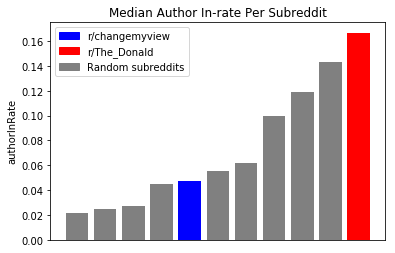

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
    
def subAvgPlot(counts, ylabel,title):
    colours = ['grey']*len(counts)
    colours[counts.index.get_loc('changemyview')] = 'blue'
    colours[counts.index.get_loc('The_Donald')] = 'red'

    height = counts.values
    bars = counts.index
    y_pos = np.arange(len(bars))

    plt.bar(y_pos, height, color=colours, label='random subs')
    
    cmv = mpatches.Patch(color='blue', label='r/changemyview')
    td = mpatches.Patch(color='red', label='r/The_Donald')
    random = mpatches.Patch(color='gray', label='Random subreddits')
    plt.legend(handles=[cmv,td,random], loc=2)
    plt.tick_params(axis='x', which='both',bottom='off',top='off',labelbottom='off')
    
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show();
    
subAvgPlot(medians['authorInRate'].sort_values(), 'authorInRate', 'Median Author In-rate Per Subreddit')

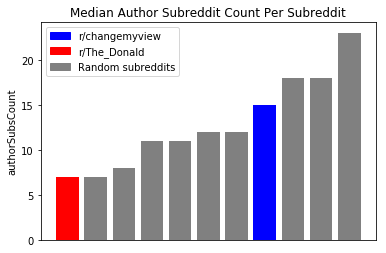

In [83]:
subAvgPlot(medians['authorSubsCount'].sort_values(), 'authorSubsCount', 'Median Author Subreddit Count Per Subreddit')

In [85]:
s = pd.read_csv('/Users/emg/Programming/GitHub/antiechochambers/data/sampleSubreddits.csv')

In [86]:
s.head()

,Unnamed: 0,subreddit,comment_count
0,0,spaceengineers,4323
1,1,antinatalism,5379
2,2,modpiracy,1154
3,3,GearsOfWar,16067
4,4,ethdev,1273


In [102]:
def getSampleAuthorOutCounts():
    grouped = df.groupby('subreddit')
    sampleAuthors = grouped['author'].apply(lambda x: x.sample(100, replace=True))
    sampleAuthors = set(sampleAuthors)

    characters = names = "'" + "','".join(sampleAuthors)+ "'"
    num_chunks = np.round(len(characters)/15000)+1
    len_chunks = np.round(len(sampleAuthors)/num_chunks)+1

    blocks = [int(len_chunks*n) for n in range (0,int(num_chunks))]
    ranges = list(zip(blocks, blocks[1:]))

    chunks = []
    authors = list(sampleAuthors)
    for r in ranges:
        start, end = r
        chunks.append(authors[start:end])
    chunks.append(authors[blocks[-1]:])

    dfs = []
    for c in tqdm(chunks):
        names = "'" + "','".join(c)+ "'"
        query = """SELECT subreddit, author, COUNT(*) as count
                        FROM `fh-bigquery.reddit_comments.2017_06`
                        WHERE (author IN ({})) and (author NOT IN ('[deleted]'))
                        GROUP BY subreddit, author""".format(names)

        df = fetchQuery(query)
        dfs.append(df)

    allCounts = pd.concat(dfs)
    assert len(authors) == len(allCounts['author'].unique()), 'incorrect # authors'
    allCounts.to_csv(data_file('sampleAuthorCommentCounts.csv'))

In [166]:
allCounts = pd.read_csv(data_file('sampleAuthorCommentCounts.csv'), index_col=0)
subByAuthorCounts = allCounts[allCounts['count']>1]

subCounts = pd.concat([subByAuthorCounts.groupby('subreddit')['author'].count(),
                       subByAuthorCounts.groupby('subreddit')['count'].sum(),
                       subByAuthorCounts.groupby('subreddit')['count'].median()],
                      axis=1)
subCounts.columns = ['subAuthorsCount', 'subCommentsCount', 'subMedianAuthorCommentsCount']
subCounts.to_csv(cache_file('sampleSubCounts.csv'))

authorCounts = pd.concat([subByAuthorCounts.groupby('author')['subreddit'].count(),
                          subByAuthorCounts.groupby('author')['count'].sum(),
                          subByAuthorCounts.groupby('author')['count'].median()],
                         axis=1)

authorCounts.columns = ['authorSubsCount', 'authorCommentsCount', 'authorMedianSubredditCommentsCount']
authorCounts.to_csv(cache_file('sampleAuthorCounts.csv'))

In [ ]:
def saveAllMerged():
    inCounts = pd.read_csv(data_file('SubredditInCounts.csv'), index_col=0)
    inCounts.columns = ['subreddit','author','inCount']

    subCounts = pd.read_csv(cache_file('subCounts.csv'), index_col=0)
    authorCounts = pd.read_csv(cache_file('authorCounts.csv'), index_col=0)

    subMerged = inCounts.merge(subCounts, left_on='subreddit', right_index=True)
    allMerged = subMerged.merge(authorCounts, left_on='author',right_index=True)
    
    allMerged.to_csv(cache_file('allMerged.csv'))

In [162]:
inCounts = pd.read_csv(data_file('SubredditInCounts.csv'), index_col=0)
inCounts.columns = ['subreddit','author','inCount']

//anaconda/envs/python3.6/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [167]:
subCounts = pd.read_csv(cache_file('sampleSubCounts.csv'), index_col=0)
authorCounts = pd.read_csv(cache_file('sampleAuthorCounts.csv'), index_col=0)

In [168]:
subMerged = inCounts.merge(subCounts, left_on='subreddit', right_index=True)
allMerged = subMerged.merge(authorCounts, left_on='author',right_index=True)

In [169]:
allMerged.head()

,subreddit,author,inCount,subAuthorsCount,subCommentsCount,subMedianAuthorCommentsCount,authorSubsCount,authorCommentsCount,authorMedianSubredditCommentsCount
22464,italy,kisstheblade69,211,26,961,6.0,5,225,5.0
348974,xmen,kisstheblade69,1,41,308,5.0,5,225,5.0
1433114,AskMen,kisstheblade69,5,131,2946,5.0,5,225,5.0
1444208,trashy,kisstheblade69,1,200,1251,4.0,5,225,5.0
1848257,todayilearned,kisstheblade69,1,700,5716,4.0,5,225,5.0


In [189]:
allMerged['authorInRate']=allMerged['inCount']/allMerged['authorCommentsCount']
engagedAuthors = allMerged[allMerged['authorCommentsCount']>10]
activeSubreddits = engagedAuthors[engagedAuthors['subAuthorsCount']>50]
medians = getAuthorMediansBySubreddit(activeSubreddits)

medians.shape

(109, 5)

In [180]:
medians = getAuthorMediansBySubreddit(engagedAuthors)
medians.head()
medians.shape

(987, 5)

(421, 5)

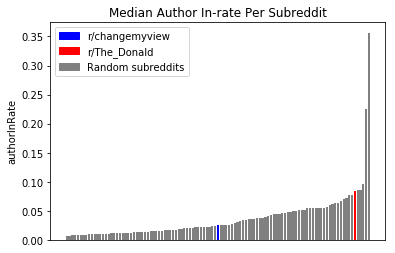

In [190]:
subAvgPlot(medians['authorInRate'].sort_values(), 'authorInRate', 'Median Author In-rate Per Subreddit')

In [188]:
allMerged['authorCommentsCount'].describe()

count     35427.000000
mean      12886.033760
std       75043.979261
min           2.000000
25%          39.000000
50%         167.000000
75%        3382.000000
max      708660.000000
Name: authorCommentsCount, dtype: float64

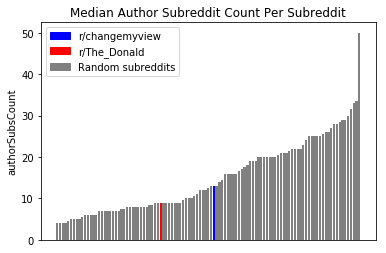

In [191]:
subAvgPlot(medians['authorSubsCount'].sort_values(), 'authorSubsCount', 'Median Author Subreddit Count Per Subreddit')